In [3]:
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import seaborn as sns
import statannotations.Annotator as statannotator
import statsmodels.api as sm
import sys

# Appending python modules so we can run simulations
sys.path.append('../python')

import json_utilities
import model_utilities
from matplotlib.pyplot import figure
from pymunk.vec2d import Vec2d
from scipy import stats

In [4]:
# Are we saving the cleaned data to a JSON?
saving_clean_data_to_dist = False
data_dir = '../data/json'

In [5]:
# Are we saving figures?
saving_figures = False
figure_dir = '../paper/figures/src'

In [6]:
sns.set_theme(
    style='whitegrid',
    palette='bright',
    font_scale=1.5,
    rc={
        'figure.dpi':300,
        'font.family':'sans-serif',
        'font.sans-serif':['Helvetica'],
    },
)


In [7]:
data_path_exp2 = '../experiments/experiment2/data/data.csv'

In [8]:
df_full_data_exp2 = pd.read_csv(data_path_exp2)

In [9]:
df_full_data_exp2['experiment_version'] = 2

In [10]:
# Removing unused columns from jsPsych
df_exp2 = df_full_data_exp2.drop(columns=['success', 
                                          'failed_images',
                                          'failed_audio',
                                          'failed_video',
                                          'time_elapsed',
                                          'scene_sp',
                                          'internal_node_id',
                                          'session_id',
                                          'study_id',
                                          'value',
                                          'stimulus',
                                          'timeout',
                                          'trial_type',
                                          'timed_out',
                                          'correct_response',
                                          'response',
                                          'task_condition',
                                         ]
                                )

In [11]:
# Copy dataframe
df_exp2 = df_exp2.loc[df_exp2.task == "response"]
# Remove the task column since we no longer are using it
df_exp2 = df_exp2.drop(columns=['task'])
# Remove attempts column since we no longer are using it
df_exp2 = df_exp2.drop(columns=['attempts',
                                'condition',
                                'trial_index',
                               ]
                      )
# Convert all scene type entries to strings
df_exp2.scene_type = df_exp2.scene_type.astype(str)
# Retain only the scene type (remove "_goalpos_" substring)
df_exp2.scene_type = df_exp2.scene_type.apply(lambda x: '_'.join(x.split('_')[:2]))
# Convert all scene entries to strings
df_exp2.scene = df_exp2.scene.astype(str)
# Retain only the scene name (remove ".mp4" substring)
df_exp2.scene = df_exp2.scene.apply(lambda x: x.split('.')[0])
# Calculate participant-wise z-score for response time
df_exp2['participant_z_rt'] = df_exp2.groupby(['experiment_version','subject_id']).rt.apply(lambda x: (x-x.mean()) / x.std())
# Determine number of datapoints lost by outlier exclusion
excluded = len(df_exp2) - len(df_exp2[abs(df_exp2.participant_z_rt) <= 2])
print(f'{excluded} of {len(df_exp2)} ({excluded/len(df_exp2)*100:.4}%) are excluded via 2-SD exclusion')
# Excluding outliers
df_exp2 = df_exp2[abs(df_exp2.participant_z_rt) <= 2]
# Rename some columns to make their values more clear.
df_exp2 = df_exp2.rename(columns={'scene_col': 'scene_collision_condition'})
# Save file locally
if saving_clean_data_to_dist:
    print('Data saved...')
    df_exp2.to_json('../data/cleaned_data/cleaned_data_exp2.json')
else:
    print('Data not saved...')

439 of 9048 (4.852%) are excluded via 2-SD exclusion
Data not saved...


In [12]:
# Directory with model fits
path_to_model_predictions = "../data/model_fits/model_fits_exp1.csv"

In [13]:
# Dataframe with model fits
model_df = pd.read_csv(path_to_model_predictions)

In [14]:
# Sort model parameters based on MSE
best_fitting_parameters = model_df[model_df['MSE Model'] <= min(model_df['MSE Model'])]
best_fitting_parameters_exp1 = best_fitting_parameters
best_fitting_parameters

,N,D,E,MSE Residual,MSE Model,MSE Total
1894691,42,386,0.91,0.24696,1.981384e-10,0.241706


In [15]:
all([model_df[model_df.N==x].D.describe()['min'] == 1 for x in set(model_df.N)])

True

In [16]:
all([model_df[model_df.N==x].D.describe()['max'] == 1000 for x in set(model_df.N)])

True

In [17]:
# Grab the best fitting parameters
n = list(best_fitting_parameters['N'])[0]
d = list(best_fitting_parameters['D'])[0]
e = list(best_fitting_parameters['E'])[0]
n,d,e

(42, 386, 0.9100000000000004)

In [18]:
# Path to jsons of scenes
path_to_scene_dir_exp2 = "../data/json/experiment2"

In [19]:
# Gather JSON files of scenes from Experiment 2
scene_json_files_exp2 = [pos_json for pos_json in os.listdir(path_to_scene_dir_exp2) if pos_json.endswith('.json')]
distance_df = pd.DataFrame({})
for scene_file in scene_json_files_exp2:
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = os.path.join(path_to_scene_dir_exp2, scene_file)
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    simulation_model = model_utilities.SimulationModel(
        {'view': False, 'noise': 0}
    )
    df_simulation_model_output = pd.DataFrame({})
    simulation_model_sample = simulation_model.sample(scene_model)
    simulation_model_sample = simulation_model_sample.model_dump()
    df_simulation_model_sample = pd.DataFrame(simulation_model_sample, index=[0])
    # Append those results to dataframe
    scene_distance_df = pd.DataFrame(
        {'scene':scene_name,
         'distance':df_simulation_model_sample['trajectory_length']
        }
    )
    distance_df = pd.concat([distance_df,scene_distance_df])

In [20]:
# Model results
# Blended model
model_blended_results_exp2 = pd.DataFrame({})
# Pure simulation model
model_simulation_results_exp2 = pd.DataFrame({})
# Pure abstraction model
model_abstraction_results_exp2 = pd.DataFrame({})
# Number of samples to take from each model
samples = 50
# Set up inference models
blended_model_parameters = {
    'view': False,
    'noise': 0.02,
    'N': n,
    'D': d,
    'E': e,
}
abstraction_model_parameters = {
    'view': False,
    'noise': 0.02,
    'N': 1,
    'D': d,
    'E': 0.0,
}
simulation_model_parameters = {
    'view': False,
    'noise': 0.0,
}

In [21]:
for scene_file in scene_json_files_exp2:
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = os.path.join(path_to_scene_dir_exp2, scene_file)
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    blended_model = model_utilities.BlendedModel(
        blended_model_parameters
    )
    df_blended_model_output = pd.DataFrame({})
    # Sample model N times
    for _ in range(samples):
        blended_model_sample = blended_model.sample(scene_model)
        blended_model_sample = blended_model_sample.model_dump()
        df_blended_model_sample = pd.DataFrame(blended_model_sample, index=[0])
        df_blended_model_output = pd.concat([df_blended_model_output, df_blended_model_sample])
    # Collect statistics from samples
    df_blended_result = pd.DataFrame(
        {'scene':scene_name,
         'collision_probability':np.mean(df_blended_model_output['collision']),
         'simulation_time':df_blended_model_output['simulation_ticks'],
         'distance':df_blended_model_output['trajectory_length'],
         'type':'blended_model'
        }
    )
    # Update results
    model_blended_results_exp2 = pd.concat([model_blended_results_exp2,df_blended_result])

In [22]:
for scene_file in scene_json_files_exp2:
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = os.path.join(path_to_scene_dir_exp2, scene_file)
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    simulation_model = model_utilities.SimulationModel(
        simulation_model_parameters
    )
    df_simulation_model_output = pd.DataFrame({})
    for _ in range(samples):
        simulation_model_sample = simulation_model.sample(scene_model)
        simulation_model_sample = simulation_model_sample.model_dump()
        df_simulation_model_sample = pd.DataFrame(simulation_model_sample, index=[0])
        df_simulation_model_output = pd.concat([df_simulation_model_output, df_simulation_model_sample])
    # Append those results to dataframe
    df_simulation_result = pd.DataFrame(
        {'scene':scene_name,
         'collision_probability':np.mean(df_simulation_model_output['collision']),
         'simulation_time':df_simulation_model_output['simulation_ticks'],
         'distance':df_simulation_model_output['trajectory_length'],
         'type':'blended_model'
        }
    )
    model_simulation_results_exp2 = pd.concat([model_simulation_results_exp2,df_simulation_result])

In [25]:
for scene_file in scene_json_files_exp2:
    print(f'Scene file {scene_file}')
    # Get scene name
    scene_name = scene_file.split('.')[0]
    # Get path to scene file
    path_to_scene_file = os.path.join(path_to_scene_dir_exp2, scene_file)
    # Parse file into a scene pydantic model
    scene_model = json_utilities.json_file_to_model(path_to_scene_file)
    # Get model results for simulation and and blended model
    abstraction_model = model_utilities.BlendedModel(
        abstraction_model_parameters
    )
    df_abstraction_model_output = pd.DataFrame({})
    # Sample model N times
    for _ in range(samples):
        abstraction_model_sample = abstraction_model.sample(scene_model)
        abstraction_model_sample = abstraction_model_sample.model_dump()
        df_abstraction_model_sample = pd.DataFrame(abstraction_model_sample, index=[0])
        df_abstraction_model_output = pd.concat([df_abstraction_model_output, df_abstraction_model_sample])
    # Collect statistics from samples
    df_abstraction_result = pd.DataFrame(
        {'scene':scene_name,
         'collision_probability':np.mean(df_abstraction_model_output['collision']),
         'simulation_time':df_abstraction_model_output['simulation_ticks'],
         'distance':df_abstraction_model_output['trajectory_length'],
         'type':'blended_model'
        }
    )
    # Update results
    model_abstraction_results_exp2 = pd.concat([model_abstraction_results_exp2,df_abstraction_result])

Scene file scene_2_26.json
Scene file scene_1_20.json
Scene file scene_1_2.json
Scene file scene_2_7.json
Scene file scene_2_10.json
Scene file scene_1_16.json
Scene file scene_1_17.json
Scene file scene_2_11.json
Scene file scene_2_6.json
Scene file scene_1_3.json
Scene file scene_1_21.json
Scene file scene_2_27.json
Scene file scene_1_4.json
Scene file scene_2_1.json
Scene file scene_2_16.json
Scene file scene_1_10.json
Scene file scene_2_20.json
Scene file scene_1_8.json
Scene file scene_1_26.json
Scene file scene_1_27.json
Scene file scene_1_9.json
Scene file scene_2_21.json
Scene file scene_1_11.json
Scene file scene_2_17.json
Scene file scene_2_0.json
Scene file scene_1_5.json
Scene file scene_1_12.json
Scene file scene_2_14.json
Scene file scene_2_3.json
Scene file scene_1_28.json
Scene file scene_1_6.json
Scene file scene_2_18.json
Scene file scene_1_24.json
Scene file scene_2_22.json
Scene file scene_2_23.json
Scene file scene_1_25.json
Scene file scene_2_19.json
Scene file sc

In [26]:
blended_model_acc = model_blended_results_exp2.groupby('scene').collision_probability.mean().to_frame()
blended_model_acc['model'] = 'blended'
blended_model_acc = blended_model_acc.rename(columns={'collision_probability': 'correct'})

In [27]:
simulation_model_acc = model_simulation_results_exp2.groupby('scene').collision_probability.mean().to_frame()
simulation_model_acc['model'] = 'simulation'
simulation_model_acc = simulation_model_acc.rename(columns={'collision_probability': 'correct'})

In [28]:
abstraction_model_acc = model_abstraction_results_exp2.groupby('scene').collision_probability.mean().to_frame()
abstraction_model_acc['model'] = 'abstraction'
abstraction_model_acc = abstraction_model_acc.rename(columns={'collision_probability': 'correct'})

In [29]:
empirical_acc = df_exp2.groupby('scene').correct.mean().to_frame()
empirical_acc['model'] = 'empirical'

In [30]:
accuracy_df = pd.concat([simulation_model_acc, empirical_acc, blended_model_acc, abstraction_model_acc])

In [31]:
accuracy_df = accuracy_df.reset_index()
accuracy_df['goal_point_idx'] = accuracy_df.scene.apply(lambda x: x.split('_')[-1])
accuracy_df['scene_type'] = accuracy_df.scene.apply(lambda x: x.split('_')[1])
accuracy_df = accuracy_df.merge(distance_df, on='scene')

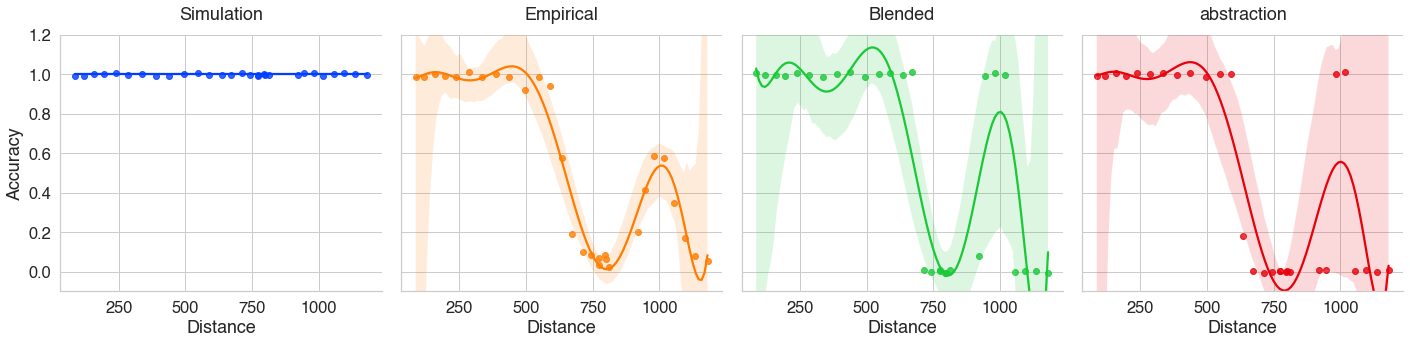

In [32]:
ax = sns.lmplot(
    data=accuracy_df[accuracy_df.scene_type =='1'],
    x="distance",
    y="correct",
    hue='model',
    order=8,
    col='model',
    y_jitter=.01,
)
ax.set(ylim=(-0.1,1.2))
axes = ax.axes.flatten()
axes[0].set_title('Simulation',pad=15)
axes[1].set_title('Empirical', pad=15)
axes[2].set_title('Blended', pad=15)
axes[3].set_title('abstraction', pad=15)
ax.set_axis_labels(x_var='Distance', y_var='Accuracy')

if True:
    plt.savefig(f'{figure_dir}/exp2_results_panel.pdf')

In [33]:
pivot = accuracy_df.pivot(index='scene', columns='model', values='correct')
pivot = pivot.merge(distance_df, on ='scene')

In [34]:
pivot['simulation'] = pivot.simulation.apply(lambda x: x*np.random.normal(1,0.001))

In [35]:
mse_empirical_blended = np.mean((pivot['empirical'] - pivot['blended'])**2)
mse_empirical_simulation = np.mean((pivot['empirical'] - pivot['simulation'])**2)
mse_empirical_abstraction = np.mean((pivot['empirical'] - pivot['abstraction'])**2)

In [36]:
mse_empirical_blended

0.030670264110642272

In [37]:
mse_empirical_simulation

0.19246259922712347

In [38]:
mse_empirical_abstraction

0.01723246138135813

In [39]:
mle_blended = -58/2*(np.log(2*np.pi*mse_empirical_blended)+1)

In [40]:
mle_abstraction = -58/2*(np.log(2*np.pi*mse_empirical_abstraction)+1)

In [41]:
mle_simulation = -58/2*(np.log(2*np.pi*mse_empirical_simulation)+1)

In [42]:
mle_abstraction

35.46941621715684

In [43]:
mle_simulation

-34.5106853439246

In [44]:
# BIC
3*np.log(58) - 2*np.log(mle_blended)

6.3188397618894525

In [45]:
# BIC
2*np.log(58) - 2*np.log(mle_abstraction)

0.9835444007841003

In [46]:
# BIC
2*np.log(58) - 2*np.log(mle_simulation)

/var/folders/ll/n97j7j6n4hl40jzcp14wv24m0000gn/T/ipykernel_61355/2040747307.py:2: RuntimeWarning: invalid value encountered in log
  2*np.log(58) - 2*np.log(mle_simulation)


nan